## Load packages and read in data

In [ ]:
# These only worked for me in Google Colab (need python version 3.11 or earlier)
%pip install --quiet sentence_transformers
import torch
from sentence_transformers import SentenceTransformer

In [ ]:
%pip install --quiet fitz
%pip install --quiet PyMuPDF

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import nltk
from collections import Counter
from wordcloud import WordCloud
import re
from sklearn.metrics.pairwise import cosine_similarity
import fitz
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jerramclaughlin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jerramclaughlin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jerramclaughlin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv('/Users/jerramclaughlin/Policy-Language-Analysis/cleaned_data/BP_AR_3514.1_cleaned.csv')

In [3]:
data.head()

,Unnamed: 0,CDS Code,County,District Name,Locale Classifications,District Type,2023-24 Student Enrollment,2023-24 % Unduplicated,BP: 3514.1 Hazardous Substances,BP 3514.1 Year Adopted,...,Staff Capacity Indicators (up to 4),W/O Policy Environmental and Climate Action Score (17 points),"Plans, Communication, and Awards Indicators (up to 3)",District-Wide Campus Sustainability Indicators (up to 3),District-Wide Environmental Community and Culture Indicators (up to 3),Environmental and Climate Action Score (20 points),BP3514.1: Path to PDF,BP3514.1: PDF Text,AR3514.1: Path to PDF,AR3514.1: PDF Text
0,0,1611190000000,Alameda,Alameda Unified,Suburban,Unified School District,10557,41,1,2009,...,1,11.0,2.5,3.0,1.5,14.0,Alameda_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Alameda_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...
1,1,1611500000000,Alameda,Castro Valley Unified,Suburban,Unified School District,9489,43,1,2018,...,0,7.5,1.0,3.0,1.5,10.5,Castro_Valley_Unified_BP3514_1.pdf,book board policy section 3000 business nonins...,Castro_Valley_Unified_AR3514_1.pdf,book board policy section 3000 business nonins...
2,2,1611680000000,Alameda,Emery Unified,Suburban,Unified School District,600,81,1,2004,...,0,3.0,0.0,2.5,0.5,6.0,Emery_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Emery_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...
3,3,1611920000000,Alameda,Hayward Unified,Suburban,Unified School District,20190,82,1,1991,...,0,5.5,0.5,3.0,0.5,8.5,Hayward_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Hayward_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...
4,4,1612000000000,Alameda,Livermore Valley Joint Unified,Urban,Unified School District,13019,27,1,2009,...,2,8.0,1.5,2.5,1.0,11.0,Livermore_Valley_Joint_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Livermore_Valley_Joint_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...


In [4]:
# looking at data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 41 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Unnamed: 0                                                                       714 non-null    int64  
 1   CDS Code                                                                         714 non-null    int64  
 2   County                                                                           714 non-null    object 
 3   District Name                                                                    714 non-null    object 
 4   Locale Classifications                                                           714 non-null    object 
 5   District Type                                                                    714 non-null    object 
 6   2023-24 St

## 2. Word Count Analysis

In [5]:
# create a column with the word count for each BP and AR
data['BP3514.1: Word Count'] = data['BP3514.1: PDF Text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
data['AR3514.1: Word Count'] = data['AR3514.1: PDF Text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

In [6]:
# subset numeric columns
#data_subset = data[['BP3514.1: Word Count', 'AR3514.1: Word Count', 'Building Electrification',
                    #'Energy Efficiency', 'On-Site Renewables',
                    #'HVAC: AC', 'Indoor Air Quality', 'Energy Resilience',
                    #'Fleet Electrification', 'EV Chargers for Parking',
                    #'Water Conservation', 'Zero Waste Initiative', 'Schoolyard Forest', 'School Gardens',
                    #'District-Wide Curriculum Environmental or Climate Literacy Indicators (up to 3)',
                    #'Overall District Action and Literacy Initiative Indicators (up to 10)',
                    #'Staff Capacity Indicators (up to 4)',
                    #'W/O Policy Environmental and Climate Action Score (17 points)',
                    #'Plans, Communication, and Awards Indicators (up to 3)',
                    #'District-Wide Campus Sustainability Indicators (up to 3)',
                    #'District-Wide Environmental Community and Culture Indicators (up to 3)',
                    #'Environmental and Climate Action Score (20 points)']].copy()
# sub data to word counts and scores
wc_and_scores_df = data[['BP3514.1: Word Count', 'AR3514.1: Word Count',
                         'District-Wide Curriculum Environmental or Climate Literacy Indicators (up to 3)',
                         'Overall District Action and Literacy Initiative Indicators (up to 10)',
                         'Staff Capacity Indicators (up to 4)',
                         'W/O Policy Environmental and Climate Action Score (17 points)',
                         'Plans, Communication, and Awards Indicators (up to 3)',
                         'District-Wide Campus Sustainability Indicators (up to 3)',
                         'District-Wide Environmental Community and Culture Indicators (up to 3)',
                         'Environmental and Climate Action Score (20 points)']].copy()

In [7]:
# look at descriptive statistics
wc_and_scores_df.describe()

,BP3514.1: Word Count,AR3514.1: Word Count,District-Wide Curriculum Environmental or Climate Literacy Indicators (up to 3),Overall District Action and Literacy Initiative Indicators (up to 10),Staff Capacity Indicators (up to 4),W/O Policy Environmental and Climate Action Score (17 points),"Plans, Communication, and Awards Indicators (up to 3)",District-Wide Campus Sustainability Indicators (up to 3),District-Wide Environmental Community and Culture Indicators (up to 3),Environmental and Climate Action Score (20 points)
count,714.000000,714.000000,714.000000,714.00000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,188.620448,656.123249,0.665266,3.09909,0.446779,3.921919,0.376050,1.767857,0.518908,6.908613
std,71.134921,267.599010,0.773871,2.12728,1.021836,3.060564,0.676473,1.064099,0.583185,3.093981
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000
25%,152.000000,506.000000,0.000000,1.25000,0.000000,1.500000,0.000000,0.750000,0.000000,4.500000
50%,205.000000,807.000000,0.500000,3.00000,0.000000,3.500000,0.000000,2.000000,0.500000,6.500000
75%,209.000000,843.750000,1.000000,4.50000,0.000000,5.500000,0.500000,3.000000,1.000000,8.500000
max,804.000000,1190.000000,3.000000,9.50000,4.000000,16.000000,3.000000,3.000000,3.000000,19.000000


In [8]:
# rename score columns so they're easier to read
wc_and_scores_df = wc_and_scores_df.rename(
    {
        'District-Wide Curriculum Environmental or Climate Literacy Indicators (up to 3)': 'curriculum_score',
        'Overall District Action and Literacy Initiative Indicators (up to 10)': 'literacy_action_score',
        'Staff Capacity Indicators (up to 4)': 'staff_score',
        'W/O Policy Environmental and Climate Action Score (17 points)': 'no_policy_score',
        'Plans, Communication, and Awards Indicators (up to 3)': 'plans_score',
        'District-Wide Campus Sustainability Indicators (up to 3)': 'sustainability_score',
        'District-Wide Environmental Community and Culture Indicators (up to 3)': 'culture_score',
        'Environmental and Climate Action Score (20 points)': 'climate_action_score',
        'BP3514.1: Word Count': 'bp_wc',
        'AR3514.1: Word Count': 'ar_wc',

    },
    axis=1
)

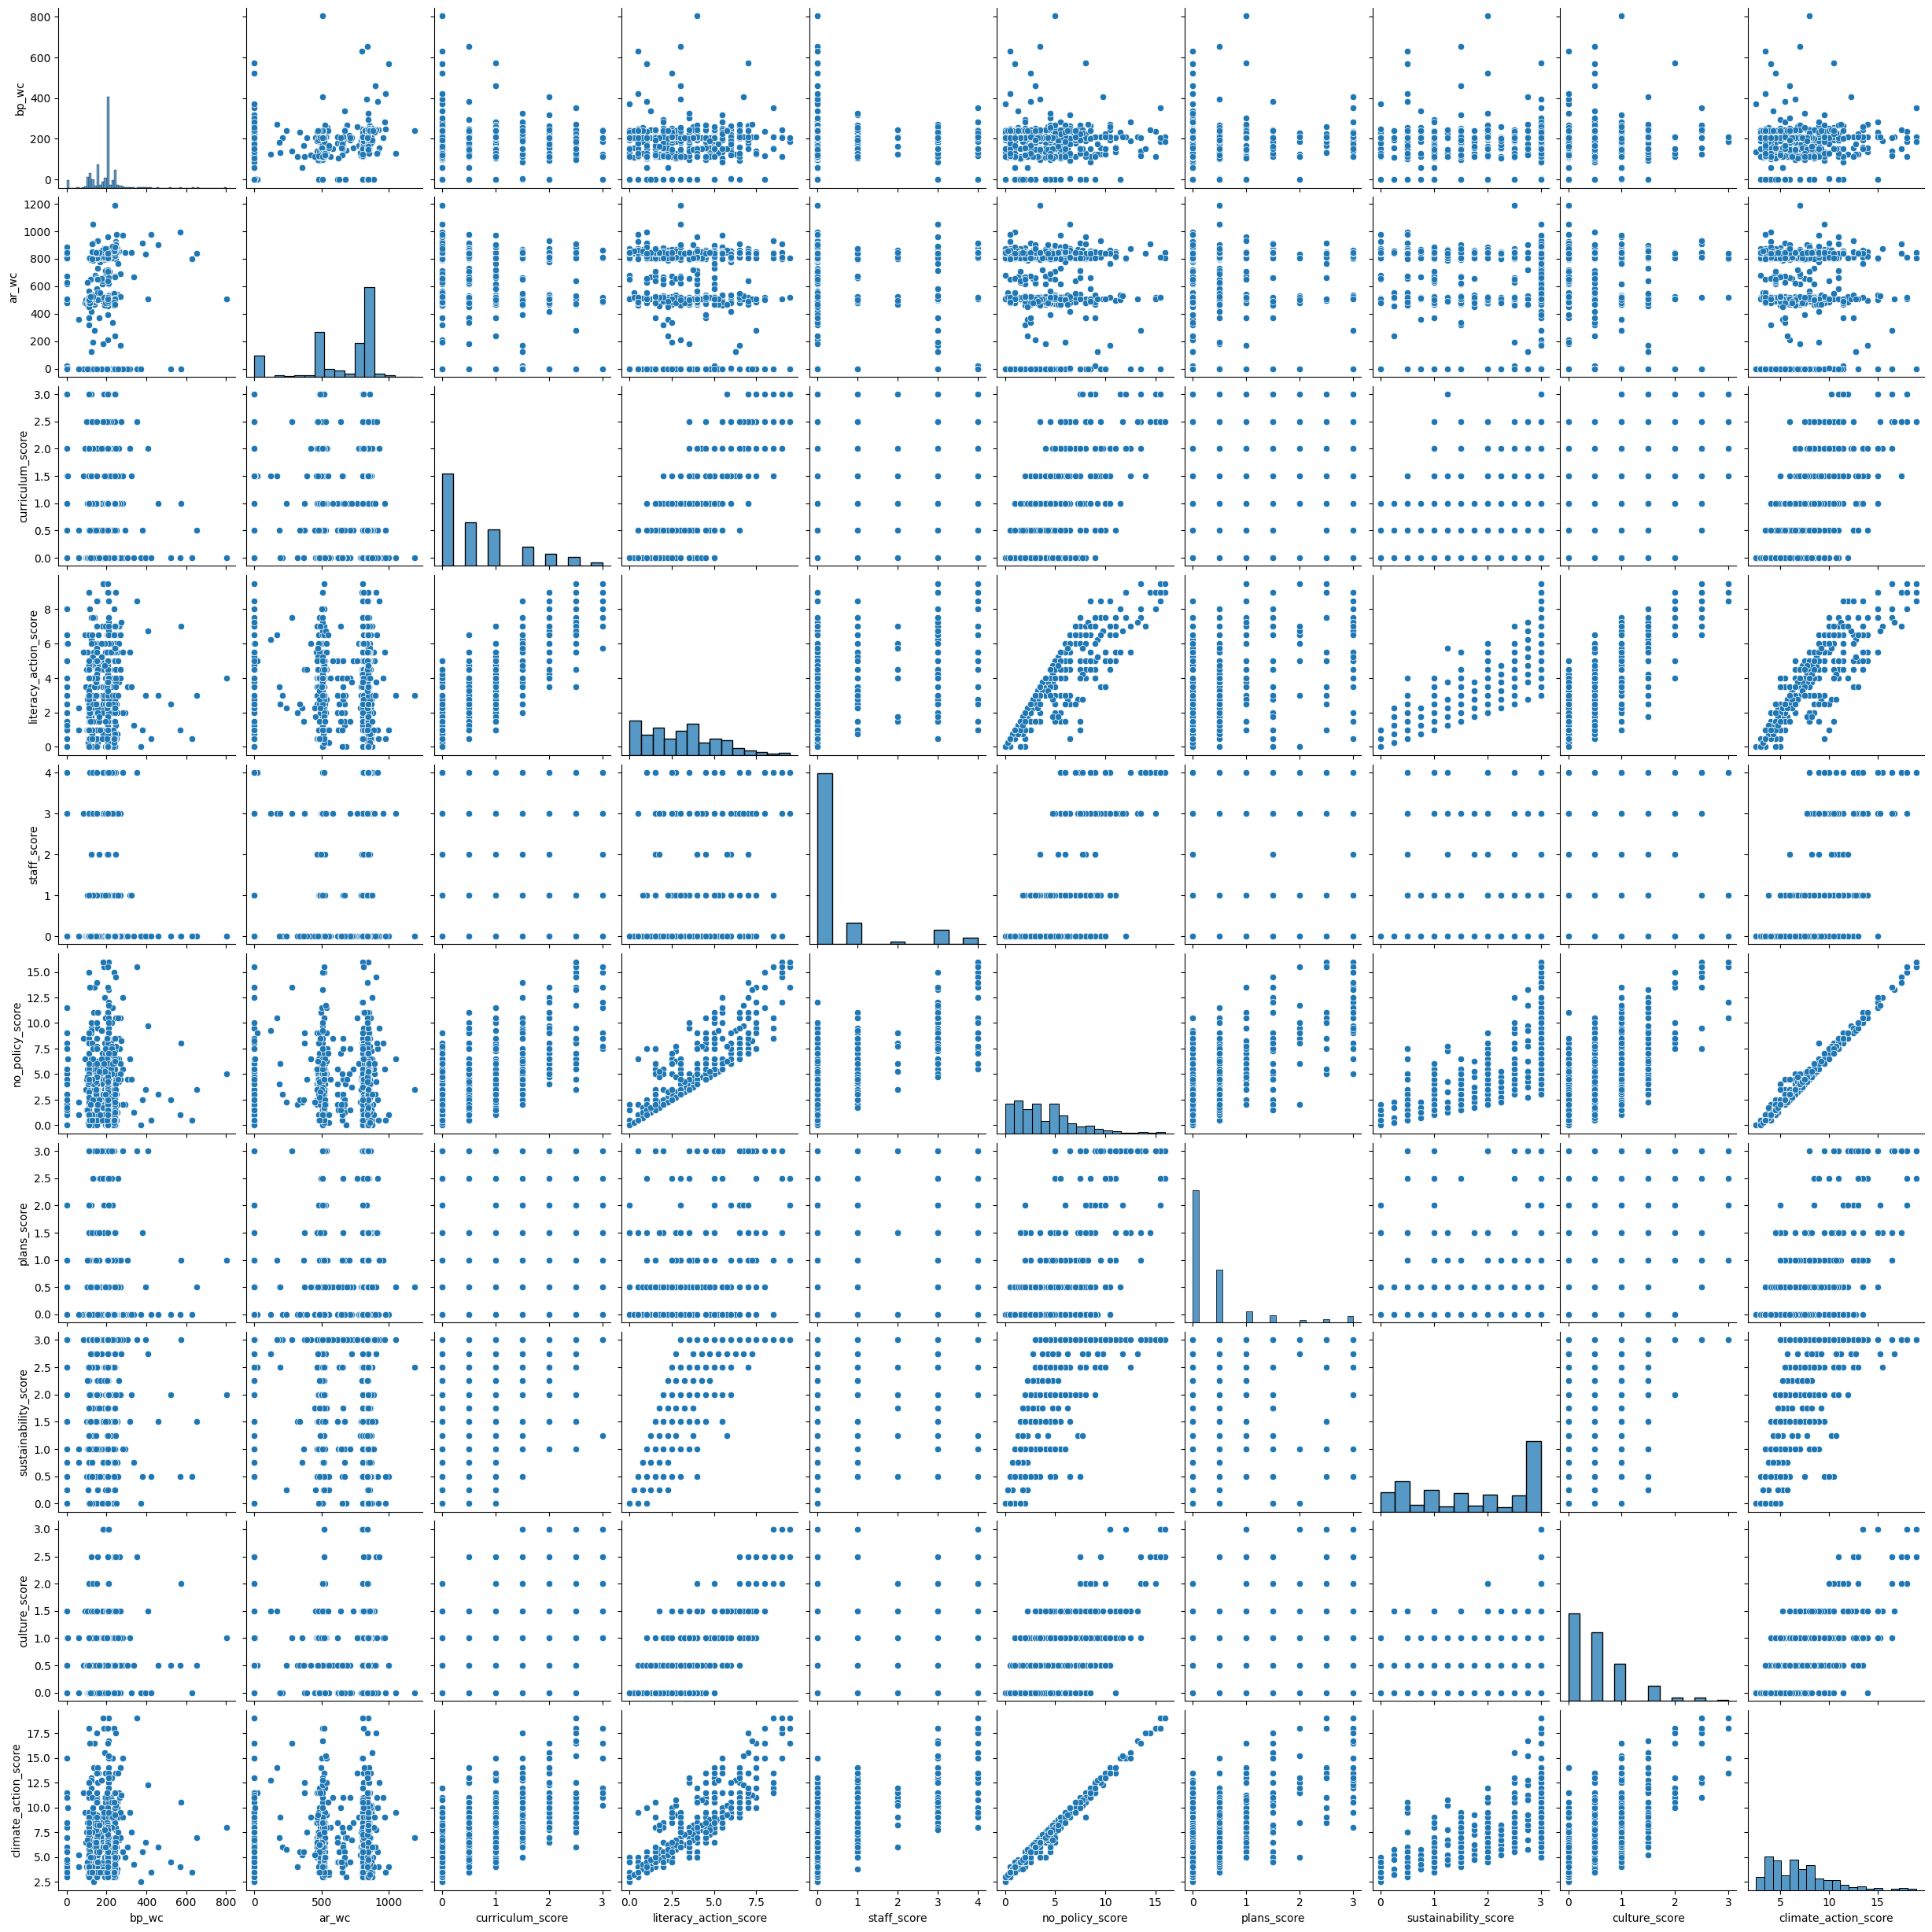

In [9]:
# Looking at the distributions of BP word count and the scores
sns.pairplot(data=wc_and_scores_df)

### Findings (Visual Inspection of word count and scores) ###

Based on visual inspection of the data, I noticed that following scores have similar distributions when plotted against the word count variables:
- group 1: `literacy_action_score`, `climate_action_score` and `no_policy_score`
- group 2: `curriculum_score`, `staff_score`, `plan_score`, and `culture_score`
- group 3: `sustainability_score` has a more unique distribution when plotted against BP3514.1 Word Count.

Despite these similarities in distributions, there does not appear to be any strong relationships between the word count variables and the scores. I will choose one score from each group to include in regression analysis to further investigate this.

Aside from word count, there appears to be some stronger relationships between scores. I will further investiagte the following relationships based on visual inspection:
- `no_policy_score` and `climate_action_score`
- `literacy_action_score` and `climate_action_score`
- `literacy_action_score` and `curriculum_score`

#### Overall District Action and Literacy Initiative Indicators ~ BP3514.1 Word Count

                              OLS Regression Results                             
Dep. Variable:     literacy_action_score   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.001
Method:                    Least Squares   F-statistic:                    0.1909
Date:                   Wed, 08 Jan 2025   Prob (F-statistic):              0.662
Time:                           21:16:53   Log-Likelihood:                -1551.5
No. Observations:                    714   AIC:                             3107.
Df Residuals:                        712   BIC:                             3116.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0067 

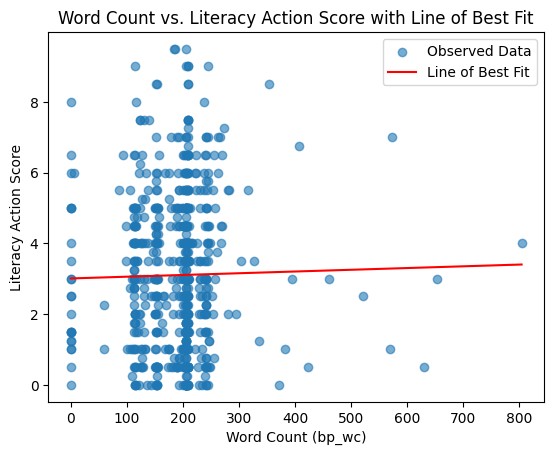

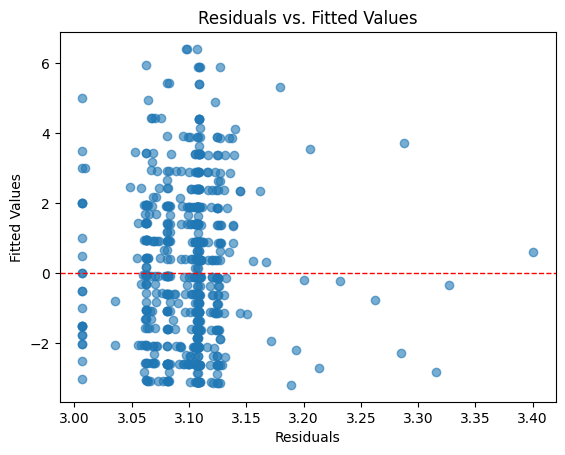

In [10]:
# fit OLS model
model_ols_wc1 = smf.ols('literacy_action_score ~ bp_wc', data=wc_and_scores_df).fit()

# Print results
print(model_ols_wc1.summary())

# Plot original data
plt.scatter(wc_and_scores_df['bp_wc'], wc_and_scores_df['literacy_action_score'], alpha=0.6, label='Observed Data')
# Generate values for the line of best fit
x = np.linspace(wc_and_scores_df['bp_wc'].min(), wc_and_scores_df['bp_wc'].max(), 100)  # Range of the predictor
y = model_ols_wc1.params['Intercept'] + model_ols_wc1.params['bp_wc'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("Word Count (bp_wc)")
plt.ylabel("Literacy Action Score")
plt.title("Word Count vs. Literacy Action Score with Line of Best Fit")
plt.legend()
plt.show()

# Plot residuals
plt.scatter(model_ols_wc1.fittedvalues, model_ols_wc1.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at residual=0
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

#### District-Wide Campus Sustainability Indicators ~ BP3514.1 Word Count

                             OLS Regression Results                             
Dep. Variable:     sustainability_score   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                    0.1437
Date:                  Wed, 08 Jan 2025   Prob (F-statistic):              0.705
Time:                          21:16:59   Log-Likelihood:                -1056.9
No. Observations:                   714   AIC:                             2118.
Df Residuals:                       712   BIC:                             2127.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8079      0.113

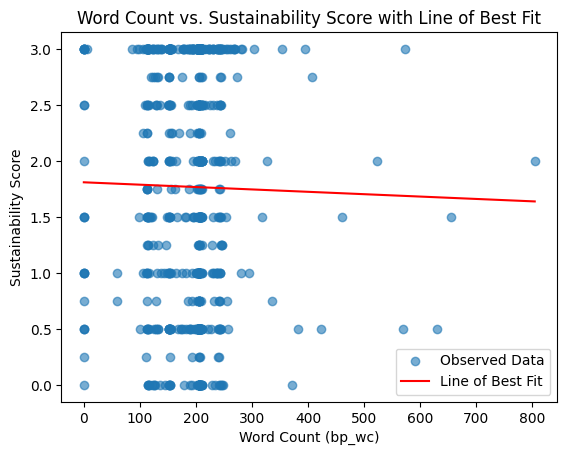

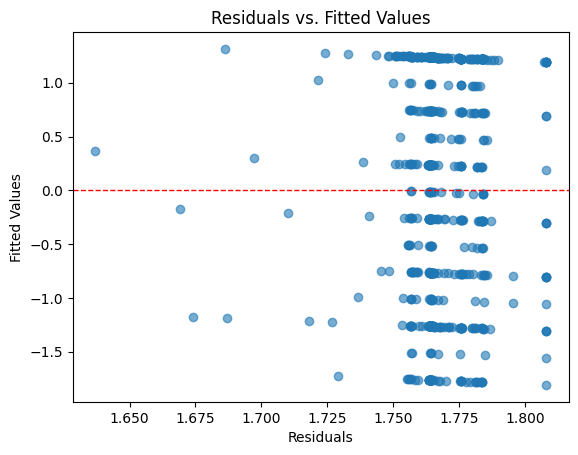

In [11]:
# fit OLS model
model_ols_wc2 = smf.ols('sustainability_score ~ bp_wc', data=wc_and_scores_df).fit()

# Print results
print(model_ols_wc2.summary())

# Plot original data
plt.scatter(wc_and_scores_df['bp_wc'], wc_and_scores_df['sustainability_score'], alpha=0.6, label='Observed Data')
# Generate values for the line of best fit
x = np.linspace(wc_and_scores_df['bp_wc'].min(), wc_and_scores_df['bp_wc'].max(), 100)  # Range of the predictor
y = model_ols_wc2.params['Intercept'] + model_ols_wc2.params['bp_wc'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("Word Count (bp_wc)")
plt.ylabel("Sustainability Score")
plt.title("Word Count vs. Sustainability Score with Line of Best Fit")
plt.legend()
plt.show()

# Plot residuals
plt.scatter(model_ols_wc2.fittedvalues, model_ols_wc2.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at residual=0
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

#### District-Wide Curriculum Environmental or Climate Literacy Indicators ~ BP3514.1 Word Count

                            OLS Regression Results                            
Dep. Variable:       curriculum_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2257
Date:                Wed, 08 Jan 2025   Prob (F-statistic):              0.635
Time:                        21:17:03   Log-Likelihood:                -829.47
No. Observations:                 714   AIC:                             1663.
Df Residuals:                     712   BIC:                             1672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7018      0.082      8.541      0.0

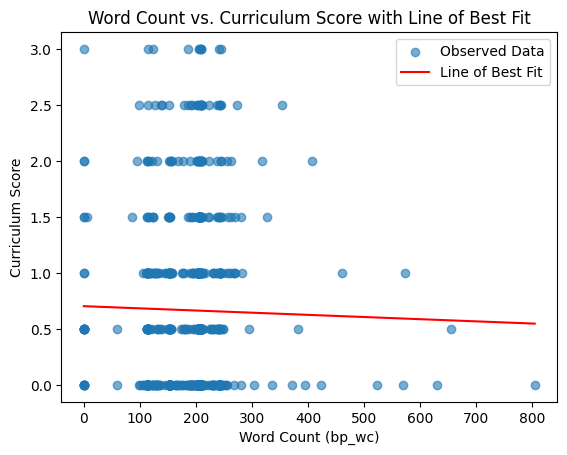

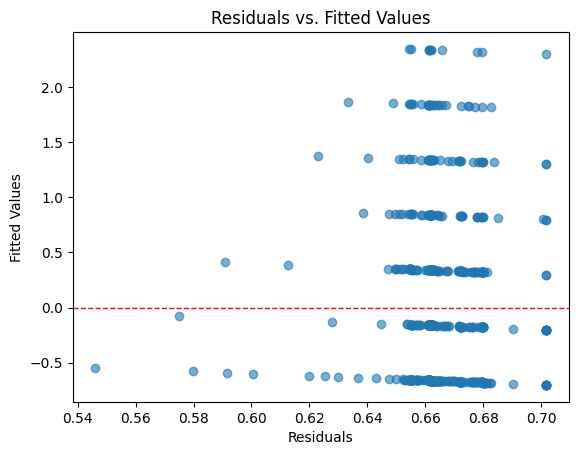

In [12]:
# fit OLS model
model_ols_wc3 = smf.ols('curriculum_score ~ bp_wc', data=wc_and_scores_df).fit()

# Print results
print(model_ols_wc3.summary())

# Plot original data
plt.scatter(wc_and_scores_df['bp_wc'], wc_and_scores_df['curriculum_score'], alpha=0.6, label='Observed Data')
# Generate values for the line of best fit
x = np.linspace(wc_and_scores_df['bp_wc'].min(), wc_and_scores_df['bp_wc'].max(), 100)  # Range of the predictor
y = model_ols_wc3.params['Intercept'] + model_ols_wc3.params['bp_wc'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("Word Count (bp_wc)")
plt.ylabel("Curriculum Score")
plt.title("Word Count vs. Curriculum Score with Line of Best Fit")
plt.legend()
plt.show()

# Plot residuals
plt.scatter(model_ols_wc3.fittedvalues, model_ols_wc3.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at residual=0
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

### BP3514.1 Regression Findings

Based on these regression models, I conclude that there is no statistically signifcant relationship between the Board Policy 3514.1 word count and the the following scores:
- Overall District Action and Literacy Initiative Indicators (`literacy_score`)
- District-Wide Campus Sustainability Indicators (`sustainability_score`)
- District-Wide Curriculum Environmental or Climate Literacy Indicators (`curriculum_score`).

Since the distributions for `climate_action_score` and `no_policy_score` are similar to `literacy_score`, it is likely these scores also have no relationship with the Board Policy 3514.1 word count.

Similarly, since the distributions for `staff_score`, `plan_score`, and `culture_score` are similar to `curriculum_score` it is likely these scores also have no relationship with the Board Policy 3514.1 word count.

#### Overall District Action and Literacy Initiative Indicators ~ AR3514.1 Word Count

                              OLS Regression Results                             
Dep. Variable:     literacy_action_score   R-squared:                       0.009
Model:                               OLS   Adj. R-squared:                  0.008
Method:                    Least Squares   F-statistic:                     6.512
Date:                   Wed, 08 Jan 2025   Prob (F-statistic):             0.0109
Time:                           21:17:07   Log-Likelihood:                -1548.3
No. Observations:                    714   AIC:                             3101.
Df Residuals:                        712   BIC:                             3110.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5957 

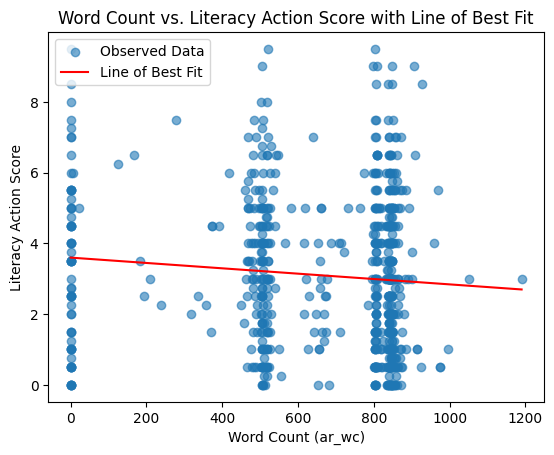

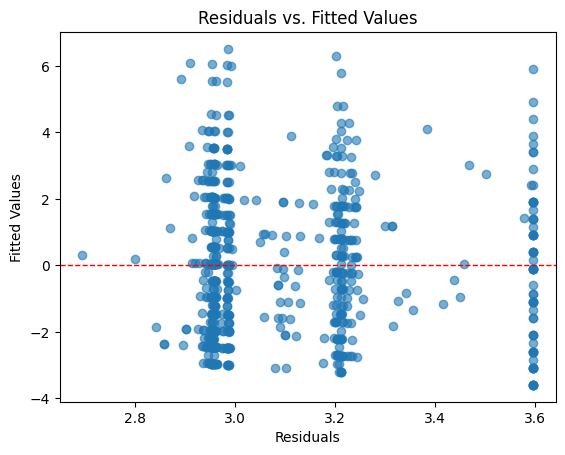

In [13]:
# fit OLS model
model_ols_wc4 = smf.ols('literacy_action_score ~ ar_wc', data=wc_and_scores_df).fit()

# Print results
print(model_ols_wc4.summary())

# Plot original data
plt.scatter(wc_and_scores_df['ar_wc'], wc_and_scores_df['literacy_action_score'], alpha=0.6, label='Observed Data')
# Generate values for the line of best fit
x = np.linspace(wc_and_scores_df['ar_wc'].min(), wc_and_scores_df['ar_wc'].max(), 100)  # Range of the predictor
y = model_ols_wc4.params['Intercept'] + model_ols_wc4.params['ar_wc'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("Word Count (ar_wc)")
plt.ylabel("Literacy Action Score")
plt.title("Word Count vs. Literacy Action Score with Line of Best Fit")
plt.legend()
plt.show()

# Plot residuals
plt.scatter(model_ols_wc4.fittedvalues, model_ols_wc4.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at residual=0
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

#### District-Wide Campus Sustainability Indicators ~ AR3514.1 Word Count

                             OLS Regression Results                             
Dep. Variable:     sustainability_score   R-squared:                       0.004
Model:                              OLS   Adj. R-squared:                  0.003
Method:                   Least Squares   F-statistic:                     2.892
Date:                  Wed, 08 Jan 2025   Prob (F-statistic):             0.0895
Time:                          21:17:11   Log-Likelihood:                -1055.5
No. Observations:                   714   AIC:                             2115.
Df Residuals:                       712   BIC:                             2124.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9338      0.105

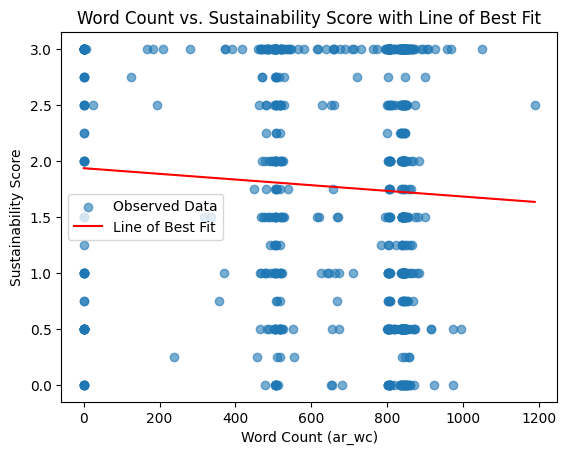

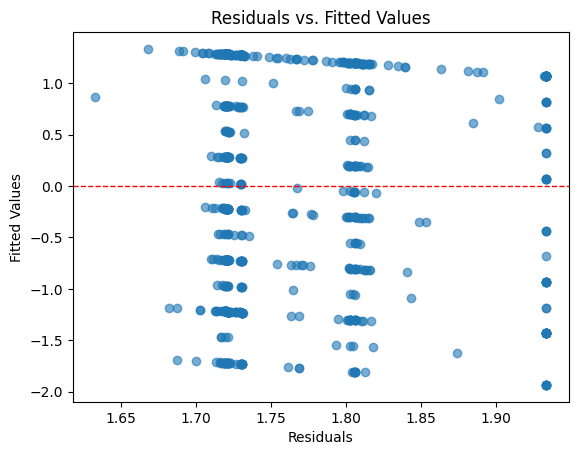

In [14]:
# fit OLS model
model_ols_wc5 = smf.ols('sustainability_score ~ ar_wc', data=wc_and_scores_df).fit()

# Print results
print(model_ols_wc5.summary())

# Plot original data
plt.scatter(wc_and_scores_df['ar_wc'], wc_and_scores_df['sustainability_score'], alpha=0.6, label='Observed Data')
# Generate values for the line of best fit
x = np.linspace(wc_and_scores_df['ar_wc'].min(), wc_and_scores_df['ar_wc'].max(), 100)  # Range of the predictor
y = model_ols_wc5.params['Intercept'] + model_ols_wc5.params['ar_wc'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("Word Count (ar_wc)")
plt.ylabel("Sustainability Score")
plt.title("Word Count vs. Sustainability Score with Line of Best Fit")
plt.legend()
plt.show()

# Plot residuals
plt.scatter(model_ols_wc5.fittedvalues, model_ols_wc5.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at residual=0
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

#### District-Wide Curriculum Environmental or Climate Literacy Indicators ~ AR3514.1 Word Count

                            OLS Regression Results                            
Dep. Variable:       curriculum_score   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.518
Date:                Wed, 08 Jan 2025   Prob (F-statistic):             0.0109
Time:                        21:17:16   Log-Likelihood:                -826.33
No. Observations:                 714   AIC:                             1657.
Df Residuals:                     712   BIC:                             1666.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8460      0.076     11.067      0.0

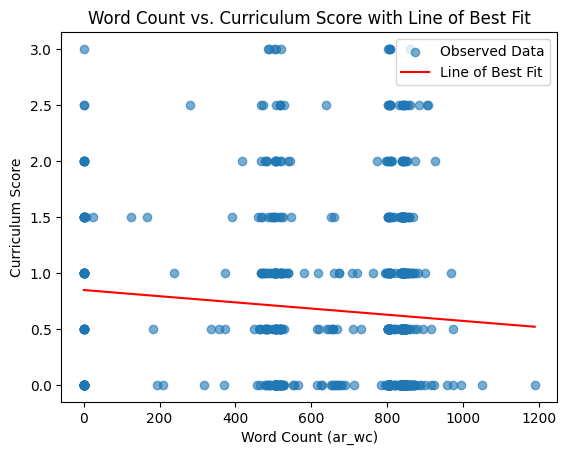

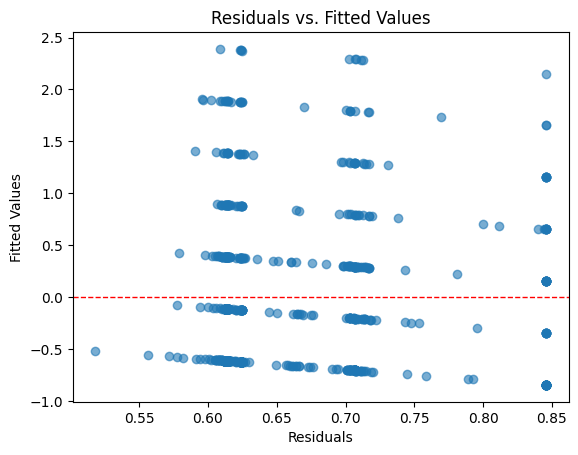

In [15]:
# fit OLS model
model_ols_wc6 = smf.ols('curriculum_score ~ ar_wc', data=wc_and_scores_df).fit()

# Print results
print(model_ols_wc6.summary())

# Plot original data
plt.scatter(wc_and_scores_df['ar_wc'], wc_and_scores_df['curriculum_score'], alpha=0.6, label='Observed Data')
# Generate values for the line of best fit
x = np.linspace(wc_and_scores_df['ar_wc'].min(), wc_and_scores_df['ar_wc'].max(), 100)  # Range of the predictor
y = model_ols_wc6.params['Intercept'] + model_ols_wc6.params['ar_wc'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("Word Count (ar_wc)")
plt.ylabel("Curriculum Score")
plt.title("Word Count vs. Curriculum Score with Line of Best Fit")
plt.legend()
plt.show()

# Plot residuals
plt.scatter(model_ols_wc6.fittedvalues, model_ols_wc6.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at residual=0
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

### AR3514.1 Regression Findings

Based on these regression models, I cannot conclude that there is any statistically signifcant relationship between the Administrative Regulation 3514.1 word count and the the following scores:
- Overall District Action and Literacy Initiative Indicators (`literacy_score`)
- District-Wide Campus Sustainability Indicators (`sustainability_score`)
- District-Wide Curriculum Environmental or Climate Literacy Indicators (`curriculum_score`).

For `literacy_score`, the p-value is 0.011, which is statistically significant at the 5% level. However, the coefficient on the word count is very close to zero (-0.0008) and there are multicolliniarity issues that make this result unreliable. The same factors are present in the models for `sustainability_score` and `curriculum_score`; they all have multicollinearity and coefficients very close to zero. Hence, there seems to be no relationship between AR word count and the scores.

Since the distributions for `climate_action_score` and `no_policy_score` are similar to `literacy_score`, it is likely these scores also have no relationship with the Administrative Regulation 3514.1 word count.

Similarly, since the distributions for `staff_score`, `plan_score`, and `culture_score` are similar to `curriculum_score` it is likely these scores also have no relationship with the Administrative Regulation 3514.1 word count.

**Further analysis: look at the relationships between the scores.**

# 3. Word/Phrase Frequency Analysis

In [16]:
# Define a function that will return the top 5 most frequent phrases
def top_ten_words(text):
    """
    returns the most common words/tokens in a string.
    handles non-string or null values by returning and empty list.
    """
    if not isinstance(text, str):
        return []
    list_of_words = nltk.word_tokenize(text) # gives list of tokens
    token_counts = nltk.FreqDist(list_of_words) # FreqDist gives a count for how often each part of the text occurs
    most_common = token_counts.most_common(10) # shows the top 10 words in the text
    return most_common

In [17]:
# additonal cleaning (get rid of ccr/cf)
def more_cleaning(text):
    if not isinstance(text, str):
        return []
    text = re.sub(r'cf', '', text, flags=re.IGNORECASE)
    text = re.sub(r'ccr', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

data['BP3514.1: PDF Text'] = data['BP3514.1: PDF Text'].apply(more_cleaning)
data['AR3514.1: PDF Text'] = data['AR3514.1: PDF Text'].apply(more_cleaning)

In [18]:
data['top_words_bp'] = data['BP3514.1: PDF Text'].apply(top_ten_words)
data['top_words_ar'] = data['AR3514.1: PDF Text'].apply(top_ten_words)

In [19]:
data.head()

,Unnamed: 0,CDS Code,County,District Name,Locale Classifications,District Type,2023-24 Student Enrollment,2023-24 % Unduplicated,BP: 3514.1 Hazardous Substances,BP 3514.1 Year Adopted,...,District-Wide Environmental Community and Culture Indicators (up to 3),Environmental and Climate Action Score (20 points),BP3514.1: Path to PDF,BP3514.1: PDF Text,AR3514.1: Path to PDF,AR3514.1: PDF Text,BP3514.1: Word Count,AR3514.1: Word Count,top_words_bp,top_words_ar
0,0,1611190000000,Alameda,Alameda Unified,Suburban,Unified School District,10557,41,1,2009,...,1.5,14.0,Alameda_Unified_BP3514_1.pdf,policy hazardous substance status adopted ori...,Alameda_Unified_AR3514_1.pdf,regulation hazardous substance status adopted...,209,851,"[(shall, 9), (substance, 8), (hazardous, 7), (...","[(hazardous, 33), (shall, 31), (substance, 27)..."
1,1,1611500000000,Alameda,Castro Valley Unified,Suburban,Unified School District,9489,43,1,2018,...,1.5,10.5,Castro_Valley_Unified_BP3514_1.pdf,book board policy section business noninstruc...,Castro_Valley_Unified_AR3514_1.pdf,book board policy section business noninstruc...,255,543,"[(substance, 9), (shall, 9), (hazardous, 8), (...","[(hazardous, 21), (substance, 20), (shall, 17)..."
2,2,1611680000000,Alameda,Emery Unified,Suburban,Unified School District,600,81,1,2004,...,0.5,6.0,Emery_Unified_BP3514_1.pdf,policy hazardous substance status adopted ori...,Emery_Unified_AR3514_1.pdf,regulation hazardous substance status adopted...,113,518,"[(substance, 7), (shall, 6), (hazardous, 5), (...","[(hazardous, 20), (substance, 19), (shall, 17)..."
3,3,1611920000000,Alameda,Hayward Unified,Suburban,Unified School District,20190,82,1,1991,...,0.5,8.5,Hayward_Unified_BP3514_1.pdf,policy hazardous substance status adopted ori...,Hayward_Unified_AR3514_1.pdf,regulation hazardous substance status adopted...,117,485,"[(substance, 7), (shall, 6), (hazardous, 5), (...","[(hazardous, 20), (substance, 19), (shall, 17)..."
4,4,1612000000000,Alameda,Livermore Valley Joint Unified,Urban,Unified School District,13019,27,1,2009,...,1.0,11.0,Livermore_Valley_Joint_Unified_BP3514_1.pdf,policy hazardous substance status adopted ori...,Livermore_Valley_Joint_Unified_AR3514_1.pdf,regulation hazardous substance status adopted...,211,810,"[(shall, 9), (substance, 8), (hazardous, 7), (...","[(hazardous, 33), (shall, 31), (substance, 27)..."


In [20]:
# find highest and lowest scores
max_score = data['District-Wide Campus Sustainability Indicators (up to 3)'].max()
min_score = data['District-Wide Campus Sustainability Indicators (up to 3)'].min()
print('max:', max_score)
print('min:', min_score)

max: 3.0
min: 0.0


In [21]:
# group by highest and lowest sustainability scores
high_score = data[(data['District-Wide Campus Sustainability Indicators (up to 3)'] == 3.0)].copy()
low_score = data[(data['District-Wide Campus Sustainability Indicators (up to 3)'] == 0.0)].copy()

In [22]:
# combine top words for high-scoring and low-scoring districts
hs_words_list_bp = high_score['top_words_bp'].sum()
ls_words_list_bp = low_score['top_words_bp'].sum()
hs_words_list_ar = high_score['top_words_ar'].sum()
ls_words_list_ar = low_score['top_words_ar'].sum()


# # count the occurences of each word across the top rows
hs_word_counts_bp = Counter(dict(hs_words_list_bp))
ls_word_counts_bp = Counter(dict(ls_words_list_bp))
hs_word_counts_ar = Counter(dict(hs_words_list_ar))
ls_word_counts_ar = Counter(dict(ls_words_list_ar))

# find most common words
highest_word_df_bp = pd.DataFrame(hs_word_counts_bp.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).set_index('Word')
lowest_word_df_bp = pd.DataFrame(ls_word_counts_bp.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).set_index('Word')
highest_word_df_ar = pd.DataFrame(hs_word_counts_ar.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).set_index('Word')
lowest_word_df_ar = pd.DataFrame(ls_word_counts_ar.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).set_index('Word')

In [23]:
hs_top10_bp = highest_word_df_bp.head(10)
ls_top10_bp = lowest_word_df_bp.head(10)
print('High Score Districts (BP):', hs_top10_bp)
print('Low Score Districts (BP):', ls_top10_bp)

High Score Districts (BP):                          Frequency
Word                              
employee                        18
information                     12
code                            11
shall                            9
substance                        8
communication                    8
hazardous                        7
superintendent                   7
designee                         7
superintendentprincipal          7
Low Score Districts (BP):                          Frequency
Word                              
shall                            9
substance                        8
hazardous                        7
superintendent                   7
designee                         7
superintendentprincipal          7
code                             6
used                             5
student                          4
school                           4


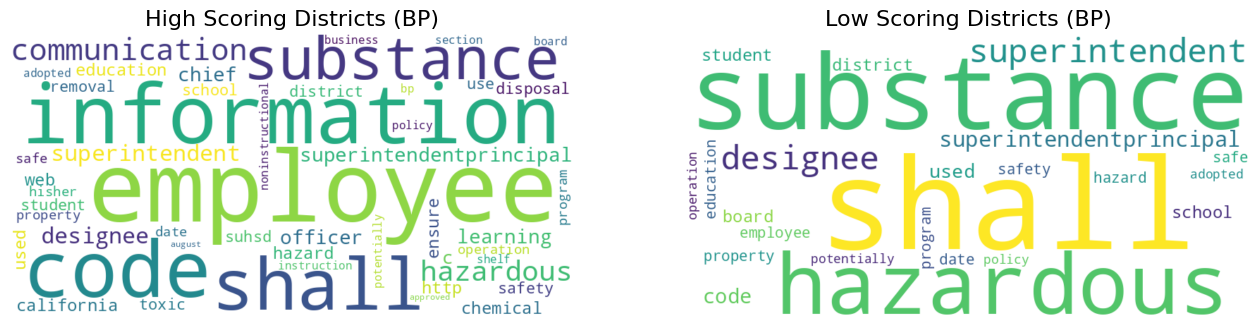

In [24]:
# Create word clouds for visualization (BP)
hs_wordcloud_bp = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hs_word_counts_bp)
ls_wordcloud_bp = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ls_word_counts_bp)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(hs_wordcloud_bp, interpolation='bilinear')
plt.axis('off')
plt.title('High Scoring Districts (BP)', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(ls_wordcloud_bp, interpolation='bilinear')
plt.axis('off')
plt.title('Low Scoring Districts (BP)', fontsize=16)

plt.show()

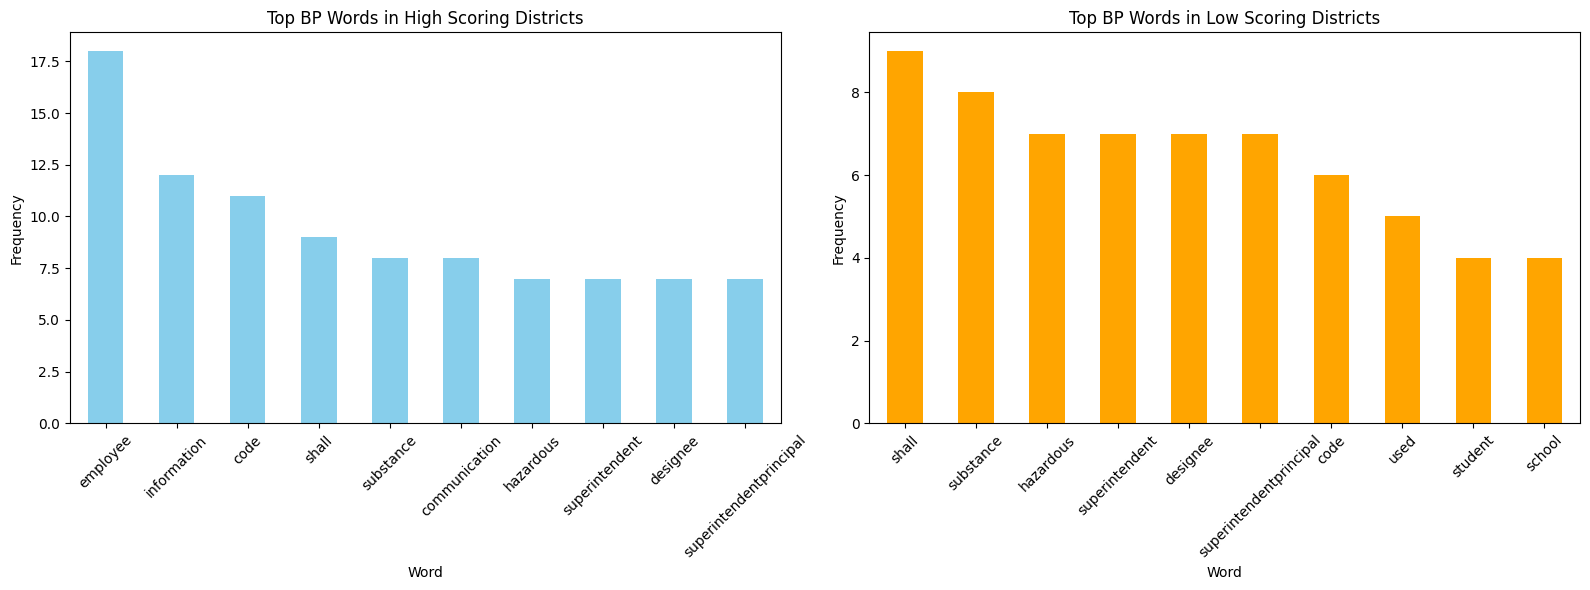

In [25]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot high-scoring district top words
hs_top10_bp.plot(kind='bar', ax=axes[0], color='skyblue', legend=False)
axes[0].set_title('Top BP Words in High Scoring Districts')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot low-scoring district top words
ls_top10_bp.plot(kind='bar', ax=axes[1], color='orange', legend=False)
axes[1].set_title('Top BP Words in Low Scoring Districts')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [26]:
hs_top10_ar = highest_word_df_ar.head(10)
ls_top10_ar = lowest_word_df_ar.head(10)
print('High Score Districts (AR):', hs_top10_ar)
print('Low Score Districts (AR):', ls_top10_ar)

High Score Districts (AR):            Frequency
Word                
hazardous         37
shall             31
substance         31
employee          22
sheet             16
data              15
material          14
training          14
may               13
district          13
Low Score Districts (AR):              Frequency
Word                  
hazardous           33
shall               31
substance           27
employee            21
chemical            14
work                13
district            13
container           13
hazard              11
information         11


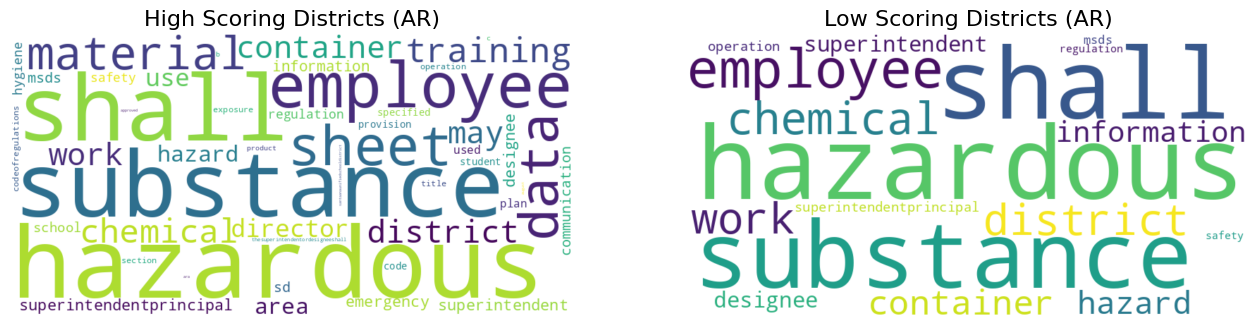

In [27]:
# Create word clouds for visualization (AR)
hs_wordcloud_ar = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hs_word_counts_ar)
ls_wordcloud_ar = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ls_word_counts_ar)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(hs_wordcloud_ar, interpolation='bilinear')
plt.axis('off')
plt.title('High Scoring Districts (AR)', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(ls_wordcloud_ar, interpolation='bilinear')
plt.axis('off')
plt.title('Low Scoring Districts (AR)', fontsize=16)

plt.show()

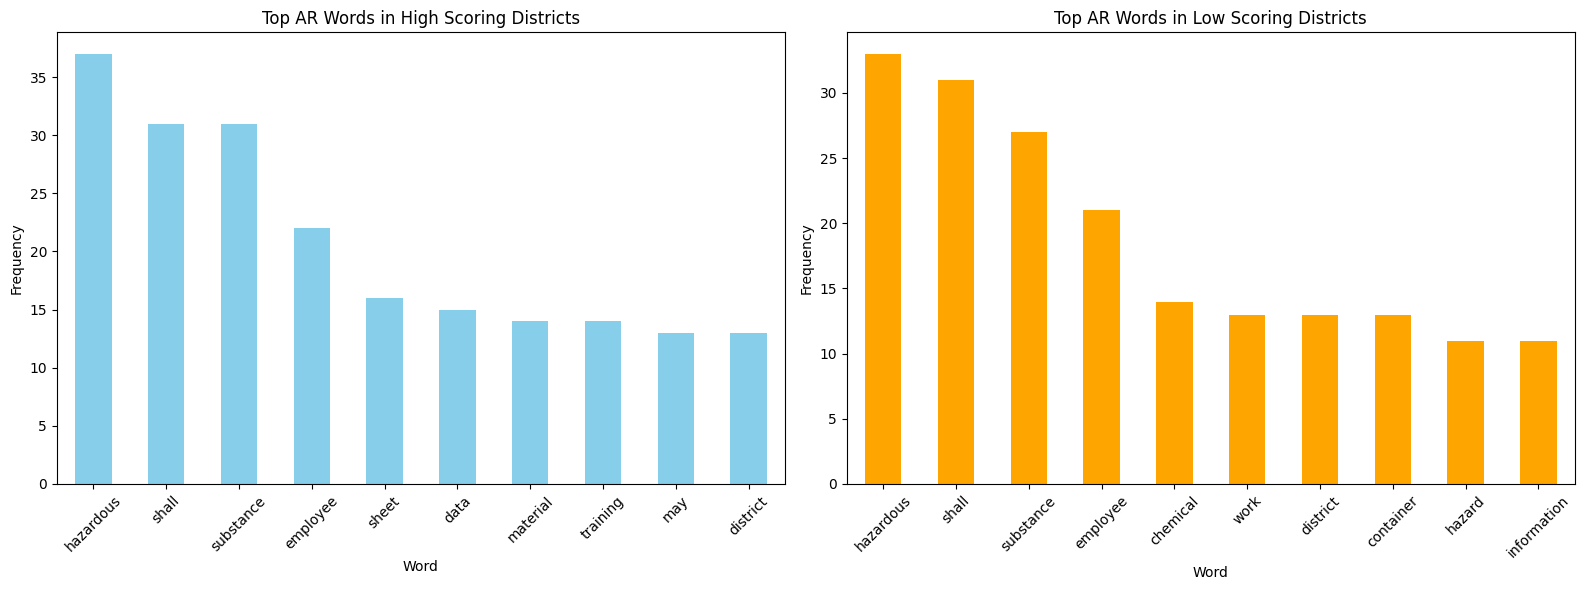

In [28]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot high-scoring district top words
hs_top10_ar.plot(kind='bar', ax=axes[0], color='skyblue', legend=False)
axes[0].set_title('Top AR Words in High Scoring Districts')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot low-scoring district top words
ls_top10_ar.plot(kind='bar', ax=axes[1], color='orange', legend=False)
axes[1].set_title('Top AR Words in Low Scoring Districts')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# 4. Template Comparison

In [ ]:
# Had to use google colab for this part because my version of python was incompatip[le with PyTorch]

In [ ]:
df = pd.read_csv("/content/BP_AR_3514.1_cleaned.csv")

In [ ]:
template_path = "/content/template_3514_1.pdf"

In [ ]:
# functions from extraction and cleaning notebook
def extract_text_from_pdf(pdf_path):
    '''Function to extract text from PDF'''
    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page in doc:
            text += page.get_text()
        if text.strip() == "":
            text = extract_text_with_ocr(pdf_path)
        return text
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return None

def clean_pdf_text(text):
    """
    Cleans up textual data by lowercasing all letters, removing punctuation, removing stop words,
    and lemmatizing.
    """
    text = re.sub(r'Education code.*$', '', text, flags=re.IGNORECASE)
    text = re.sub(r'legal reference.*', '', text, flags=re.IGNORECASE | re.DOTALL) # Use regex to remove 'legal reference' and everything after
    text = text.lower() # Lowercase text
    tokens = word_tokenize(text) # Tokenize text
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens if re.sub(r'[^\w\s]', '', token)] # Regular expression to match punctuation
    stop_words = set(stopwords.words('english')) # Define stop words
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmetize
    cleaned_text = ' '.join(tokens) # Join tokens back into a string

    return cleaned_text

In [ ]:
template = extract_text_from_pdf(template_path)
template = clean_pdf_text(template)
template

'board policy bp 35141 hazardous substance business noninstructional operation governing board desire provide safe school environment protects student employee exposure potentially hazardous substance may used district educational program maintenance operation district facility equipment cf 3514 environmental safety cf 411942421942421942 exposure control plan bloodborne pathogen cf 415742574357 employee safety cf 514122 infectious disease cf 5142 safety cf 61613 toxic art supply insofar reasonably possible superintendent designee shall minimize quantity hazardous substance stored used school property hazardous substance must used superintendent designee shall give preference material cause least risk people environment cf 3510 green school operation cf 35142 integrated pest management superintendent designee shall ensure potentially hazardous substance district property inventoried used stored regularly disposed safe legal manner superintendent designee shall develop implement maintain

In [13]:
# create an instance of the model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# subset data
BP_PDF = df['BP3514.1: PDF Text']

# define mebedding function to deal w/ null values
def get_embedding(text):
    """
    Get embeddings for a string. If the input is not a string, return a zero vector.
    """
    if not isinstance(text, str):
        return np.zeros(384)  # Return zero vector for invalid inputs
    return embedding_model.encode(text)

# get template embedding
temp_embedding = get_embedding(template)

# empty list to store cosine similarity
similarity_scores_bp = []

# iterate through each pdf text to get similarity to template
for pdf in BP_PDF:
  embedding_bp = get_embedding(pdf)
  similarity_bp = cosine_similarity([embedding_bp], [temp_embedding])
  similarity_scores_bp.append(similarity_bp[0][0])

# convert to a DataFrame
similarity_scores_bp_df = pd.DataFrame({
    'District Name': df['District Name'],
    'Similarity': similarity_scores_bp,
    'Sustainability_Score': df['District-Wide Campus Sustainability Indicators (up to 3)']
})

# sort districts by similarity score (top 10)
most_similar_bp = similarity_scores_bp_df.sort_values(by='Similarity', ascending=False).head(20)
most_similar_bp

,District Name,Similarity,Sustainability_Score
653,Burnt Ranch Elementary,0.986434,0.75
235,Sulphur Springs Union,0.983251,3.00
75,Sanger Unified,0.980855,2.50
426,Snowline Joint Unified,0.977746,3.00
524,Cupertino Union,0.977746,2.00
618,Waugh Elementary,0.977524,0.25
233,South Pasadena Unified,0.977121,2.25
523,Campbell Union High,0.976151,3.00
203,El Rancho Unified,0.976055,3.00
199,Eastside Union Elementary,0.975703,1.00


                             OLS Regression Results                             
Dep. Variable:     Sustainability_Score   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                   0.02043
Date:                  Thu, 09 Jan 2025   Prob (F-statistic):              0.886
Time:                          05:09:46   Log-Likelihood:                -1057.0
No. Observations:                   714   AIC:                             2118.
Df Residuals:                       712   BIC:                             2127.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7976      0.212

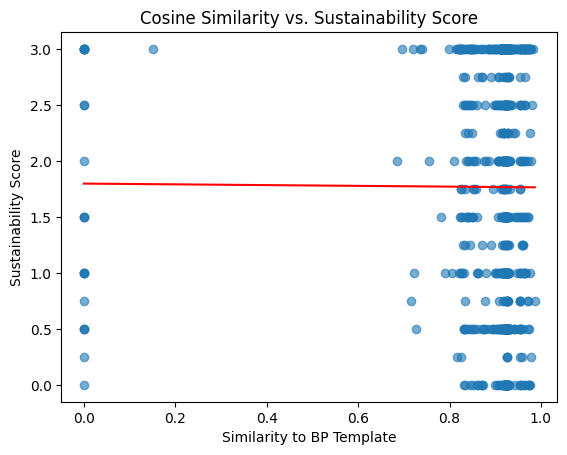

In [14]:
# fit OLS model
model_ols_wc7 = smf.ols('Sustainability_Score ~ Similarity', data=similarity_scores_bp_df).fit()

# Print results
print(model_ols_wc7.summary())

# Plot scatter plot: cosine similarty (x-axis) vs. sustainability score
plt.scatter(similarity_scores_bp_df['Similarity'], similarity_scores_bp_df['Sustainability_Score'], alpha=0.6)
# Generate values for the line of best fit
x = np.linspace(similarity_scores_bp_df['Similarity'].min(), similarity_scores_bp_df['Similarity'].max(), 100)  # Range of the predictor
y = model_ols_wc7.params['Intercept'] + model_ols_wc7.params['Similarity'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel('Similarity to BP Template')
plt.ylabel('Sustainability Score')
plt.title('Cosine Similarity vs. Sustainability Score')
plt.show()